In [1]:
import os
import pickle
import sys
import math
import json
import time
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import openturns as ot
import openturns.viewer as viewer
import openturns.viewer as otv
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker


plt.rcParams['figure.dpi']= 500

In [2]:
distribution_alpha = ot.Normal(101.6612, 4.0)
distribution_alpha.setDescription([r"$\alpha$"])
#
distribution_beta = ot.Normal(0.0233, 0.0005)
distribution_beta.setDescription([r"$\beta$"])
#
distribution_epsilon_e = ot.Triangular(0.2, 0.3, 0.5)
distribution_epsilon_e.setDescription([r"$\epsilon_e$"])
#
distribution_epsilon_c = ot.Triangular(0.0, 0.05, 0.3)
distribution_epsilon_c.setDescription([r"$\epsilon_c$"])
#
dp_factor = 1.0e-6
distribution_dp = ot.Triangular(0.5 * dp_factor, 5.0 * dp_factor, 10.0 * dp_factor)
distribution_dp.setDescription([r"$d_p$"])
#
distribution_gamma_p0 = ot.Triangular(1.0e-09, 4.5e-09, 8.0e-09)
distribution_gamma_p0.setDescription([r"$\Gamma_p(0)$"])
#
distribution_av = ot.Triangular(0.1e-4, 7.8e-4, 12e-4)
distribution_av.setDescription([r"$a_v$"])
#
distributionList = [
    distribution_alpha,
    distribution_beta,
    distribution_epsilon_e,
    distribution_epsilon_c,
    distribution_dp,
    distribution_gamma_p0,
    distribution_av,
]
distribution = ot.ComposedDistribution(distributionList)
# Workaround for https://github.com/openturns/openturns/issues/2255
labels = [marginal.getDescription()[0] for marginal in distributionList]

In [3]:
colors_ch = {'Morpholine': {'9.2': ['g', 0.05], '9.6': ['g', 0.2]},
             'ETA': {'9.2': ['b', 0.05], '9.6': ['b', 0.2]},
             'Ammoniaque' : {'9.2': ['r', 0.05], '9.7': ['r', 0.2]}}

In [4]:
input_900 = {}
input_900['CHB4GV2'] = json.load(open('/home/b99981/Desktop/These/Codes/Results/TPD/900/CHB4GV2/chb4gv2_jdd.json'))

In [5]:
dataset_BC = ot.Sample.ImportFromCSVFile('DataSet_BC.csv')
dataset_BF = ot.Sample.ImportFromCSVFile('DataSet_BF.csv')

In [6]:
inputSample = dataset_BC[:,0:7]

In [7]:
outputSample_BC = dataset_BC[:,7:]
outputSample_BF = dataset_BF[:,7:]

In [8]:
t = [i*250 for i in range(75)]

## General $R^2_{HSIC}$

In [7]:
hsic_time_BC, hsic_time_BF = [], []
estimatorType_u = ot.HSICVStat() 
p_values_BC, p_values_BF = [], []

In [8]:
for i in range(75):
    
    tauSample_BC = outputSample_BC[:,i]
    tauSample_BF = outputSample_BF[:,i]

    covarianceModelCollection_BC, covarianceModelCollection_BF = [], []
    for i in range(7):
        Xi = inputSample.getMarginal(i)
        Cov = ot.SquaredExponential(1)
        Cov.setScale(Xi.computeStandardDeviation())
        covarianceModelCollection_BC.append(Cov)
        covarianceModelCollection_BF.append(Cov)

    covarianceModelCollection_BC.append(ot.SquaredExponential(tauSample_BC.computeStandardDeviation()))
    covarianceModelCollection_BF.append(ot.SquaredExponential(tauSample_BF.computeStandardDeviation()))

    hsic_u_BC = ot.HSICEstimatorGlobalSensitivity(covarianceModelCollection_BC, inputSample, tauSample_BC, estimatorType_u)
    hsic_u_BF = ot.HSICEstimatorGlobalSensitivity(covarianceModelCollection_BF, inputSample, tauSample_BF, estimatorType_u)
    
    r2_u_BC = hsic_u_BC.getR2HSICIndices()
    r2_u_BF = hsic_u_BF.getR2HSICIndices()

    hsic_time_BC.append(list(np.abs(r2_u_BC)))
    hsic_time_BF.append(list(np.abs(r2_u_BF)))
    
    small_p_bc, small_p_bf = [],[]
    
    for j in range(7):
        small_p_bc.append(round(estimatorType_u.computePValue(ot.Gamma(), 969, hsic_u_BC.getHSICIndices()[j], 0.0),4))
        small_p_bf.append(round(estimatorType_u.computePValue(ot.Gamma(), 969, hsic_u_BF.getHSICIndices()[j], 0.0),4))

    p_values_BC.append(small_p_bc)
    p_values_BF.append(small_p_bf)


In [9]:
hsic_time_BC = list(np.transpose(np.asarray(hsic_time_BC)))
hsic_time_BF = list(np.transpose(np.asarray(hsic_time_BF)))
p_values_BC = list(np.transpose(np.asarray(p_values_BC)))
p_values_BF = list(np.transpose(np.asarray(p_values_BF)))

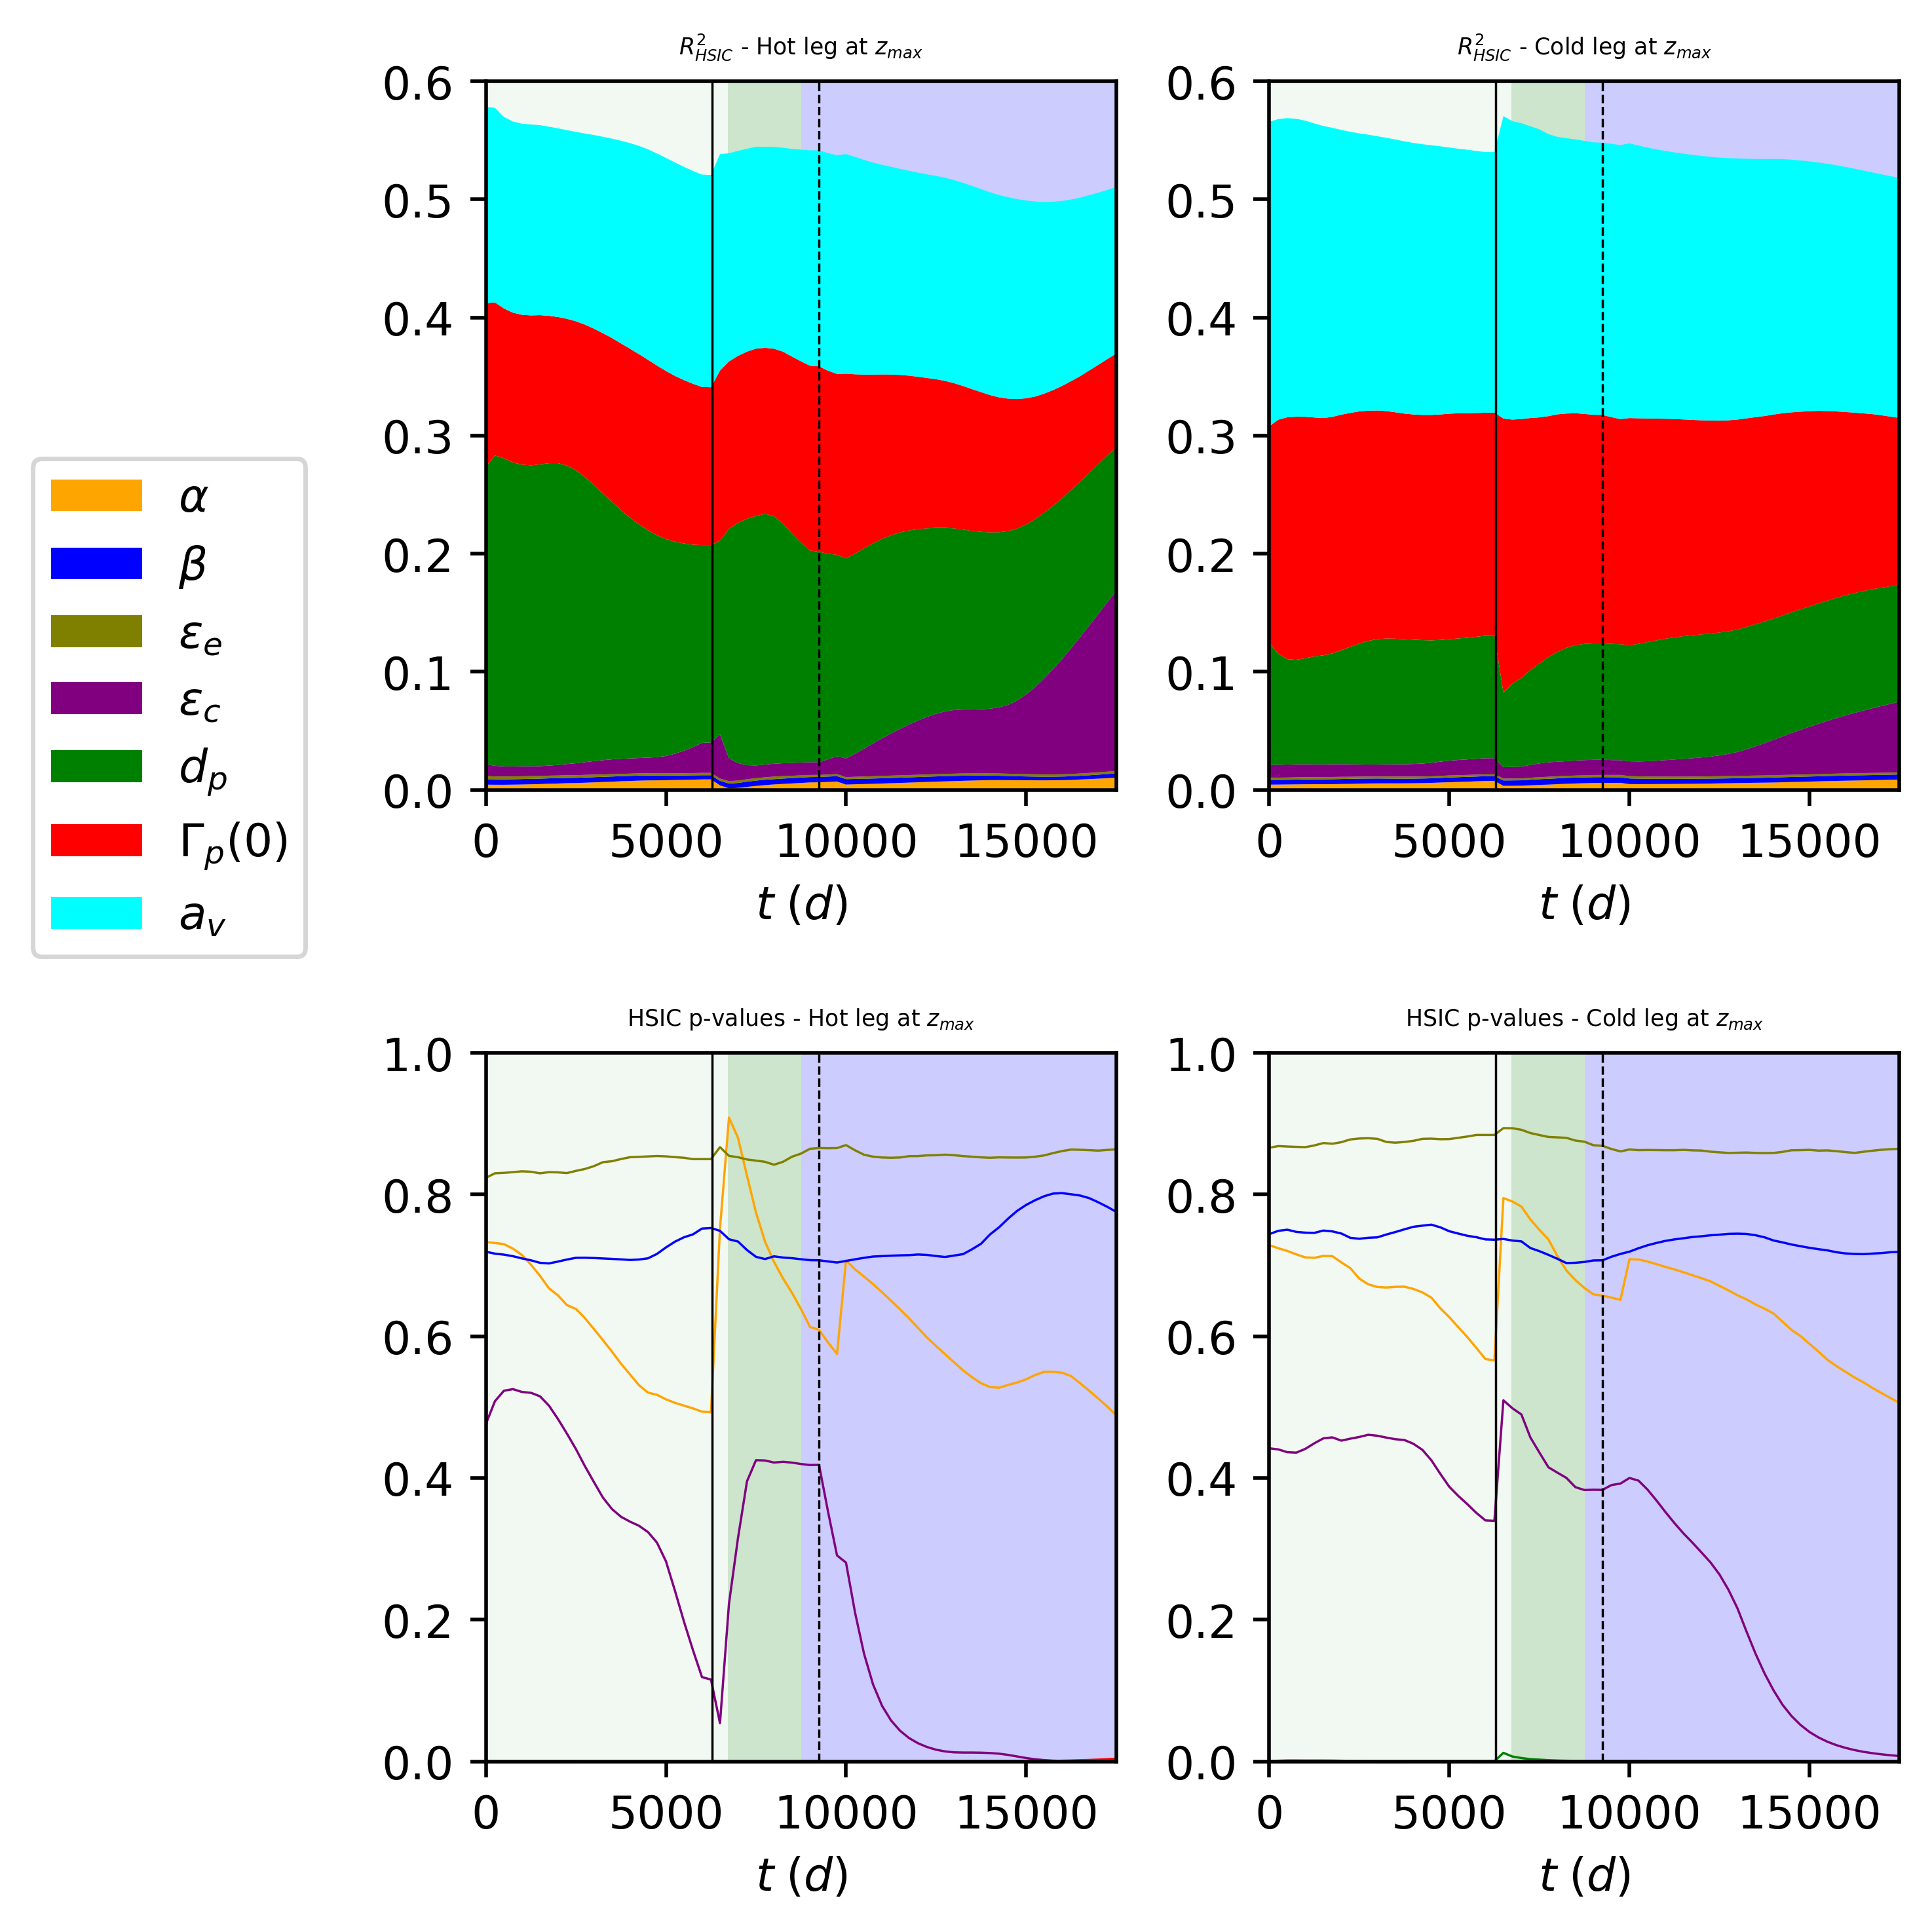

In [15]:
fig, axs = plt.subplots(2,2,figsize=(6,6),layout='tight')
colors = ['orange', 'blue', 'olive','purple', 'green', 'red','cyan']

cond = input_900['CHB4GV2']['chimie']['conditionnementSecondaire']
for k in range(len(cond)):
    if k == len(cond)-1:
        t_i, t_f = cond[k]['nbHeuresExploit']/24, max(t)
    else:
        t_i, t_f = cond[k]['nbHeuresExploit']/24, cond[k+1]['nbHeuresExploit']/24
    c = cond[k]
    typ = colors_ch[c['type']]
    col = typ[str(c['ph'])]
    axs[0,0].axvspan(t_i, t_f, facecolor=col[0], alpha = col[1])
    axs[0,1].axvspan(t_i, t_f, facecolor=col[0], alpha = col[1])
    axs[1,0].axvspan(t_i, t_f, facecolor=col[0], alpha = col[1])
    axs[1,1].axvspan(t_i, t_f, facecolor=col[0], alpha = col[1])

axs[0,0].stackplot(t,hsic_time_BC, labels=labels, colors=colors)
axs[0,0].set_xlim(0,17500)
axs[0,0].set_ylim(0,0.6)
axs[0,0].set_xlabel(r'$t\;(d)$')
axs[0,0].set_title(r'$R^{2}_{HSIC}$ - Hot leg at $z_{max}$', fontsize=5)

axs[0,1].stackplot(t,hsic_time_BF, labels=labels, colors=colors)
axs[0,1].set_xlim(0,17500)
axs[0,1].set_ylim(0,0.6)
axs[0,1].set_xlabel(r'$t\;(d)$')
axs[0,1].set_title(r'$R^{2}_{HSIC}$ - Cold leg at $z_{max}$',  fontsize=5)

for k in range(7):
    axs[1,0].plot(t,p_values_BC[k], c=colors[k], linewidth=0.5)
    axs[1,0].set_xlim(0,17500)
    axs[1,0].set_ylim(0,1.0)
    axs[1,0].set_xlabel(r'$t\;(d)$')
    axs[1,0].set_title(r'HSIC p-values - Hot leg at $z_{max}$',  fontsize=5)

    axs[1,1].plot(t,p_values_BF[k], c=colors[k], linewidth=0.5)
    axs[1,1].set_xlim(0,17500)
    axs[1,1].set_ylim(0,1.0)
    axs[1,1].set_xlabel(r'$t\;(d)$')
    axs[1,1].set_title(r'HSIC p-values - Cold leg at $z_{max}$',  fontsize=5)

axs[0,0].legend(bbox_to_anchor=(-0.25,0.5))


nett = input_900['CHB4GV2']['chimie']['nettoyage']
for k in range(len(nett)):
    if nett[k]['type'] == 'curatif':
        axs[0,0].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='-', linewidth=0.5)
        axs[0,1].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='-', linewidth=0.5)
        axs[1,0].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='-', linewidth=0.5)
        axs[1,1].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='-', linewidth=0.5)
        
    elif nett[k]['type'] == 'preventif':
        axs[0,0].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='--', linewidth=0.5)
        axs[0,1].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='--', linewidth=0.5)
        axs[1,0].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='--', linewidth=0.5)
        axs[1,1].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='--', linewidth=0.5)

fig.savefig('HSIC_tot.pdf', format='pdf')

In [ ]:
## FAIRE LES INTERVALLES PAR BOOTSTRAP SUR L'ESTIMATION DES P-VALEURS

## Target HSIC

In [11]:
hsic_target_time_BC, hsic_target_time_BF = [], []
p_values_target_BC, p_values_target_BF = [], []
estimatorType_u = ot.HSICVStat() 

In [12]:
dist = ot.DistanceToDomainFunction(ot.Interval(30, float('inf')))
func = ot.SymbolicFunction('x', 'exp(-0.5 * x)')
filterFunction= ot.ComposedFunction(func, dist)

In [13]:
for i in range(75):

    tauSample_BC = outputSample_BC[:,i]
    tauSample_BF = outputSample_BF[:,i]
    
    #filterFunction = ot.IndicatorFunction(ot.Interval(30, float('inf')))
    
    covarianceModelCollection_BC, covarianceModelCollection_BF = [], []
    
    for i in range(7):
        Xi = inputSample.getMarginal(i)
        Cov = ot.SquaredExponential(1)
        Cov.setScale(Xi.computeStandardDeviation())
        covarianceModelCollection_BC.append(Cov)
        covarianceModelCollection_BF.append(Cov)

    covarianceModelCollection_BC.append(ot.SquaredExponential(tauSample_BC.computeStandardDeviation()))
    covarianceModelCollection_BF.append(ot.SquaredExponential(tauSample_BF.computeStandardDeviation()))

    hsic_u_target_BC = ot.HSICEstimatorTargetSensitivity(covarianceModelCollection_BC, inputSample, tauSample_BC, estimatorType_u, filterFunction)
    hsic_u_target_BF = ot.HSICEstimatorTargetSensitivity(covarianceModelCollection_BF, inputSample, tauSample_BF, estimatorType_u, filterFunction)
     
    #r2_u = hsic_u.getHSICIndices()
    hsic_target_time_BC.append(hsic_u_target_BC.getR2HSICIndices())
    hsic_target_time_BF.append(hsic_u_target_BF.getR2HSICIndices())
   
    small_p_bc, small_p_bf = [], []
    for j in range(7):
        small_p_bc.append(round(estimatorType_u.computePValue(ot.Gamma(), 969, hsic_u_target_BC.getHSICIndices()[j], 0.0),4))
        small_p_bf.append(round(estimatorType_u.computePValue(ot.Gamma(), 969, hsic_u_target_BF.getHSICIndices()[j], 0.0),4))

    p_values_target_BC.append(small_p_bc)
    p_values_target_BF.append(small_p_bf)

In [14]:
hsic_target_time_BC = list(np.transpose(np.asarray(hsic_target_time_BC)))
hsic_target_time_BF = list(np.transpose(np.asarray(hsic_target_time_BF)))
p_values_target_BC = list(np.transpose(np.asarray(p_values_target_BC)))
p_values_target_BF = list(np.transpose(np.asarray(p_values_target_BF)))

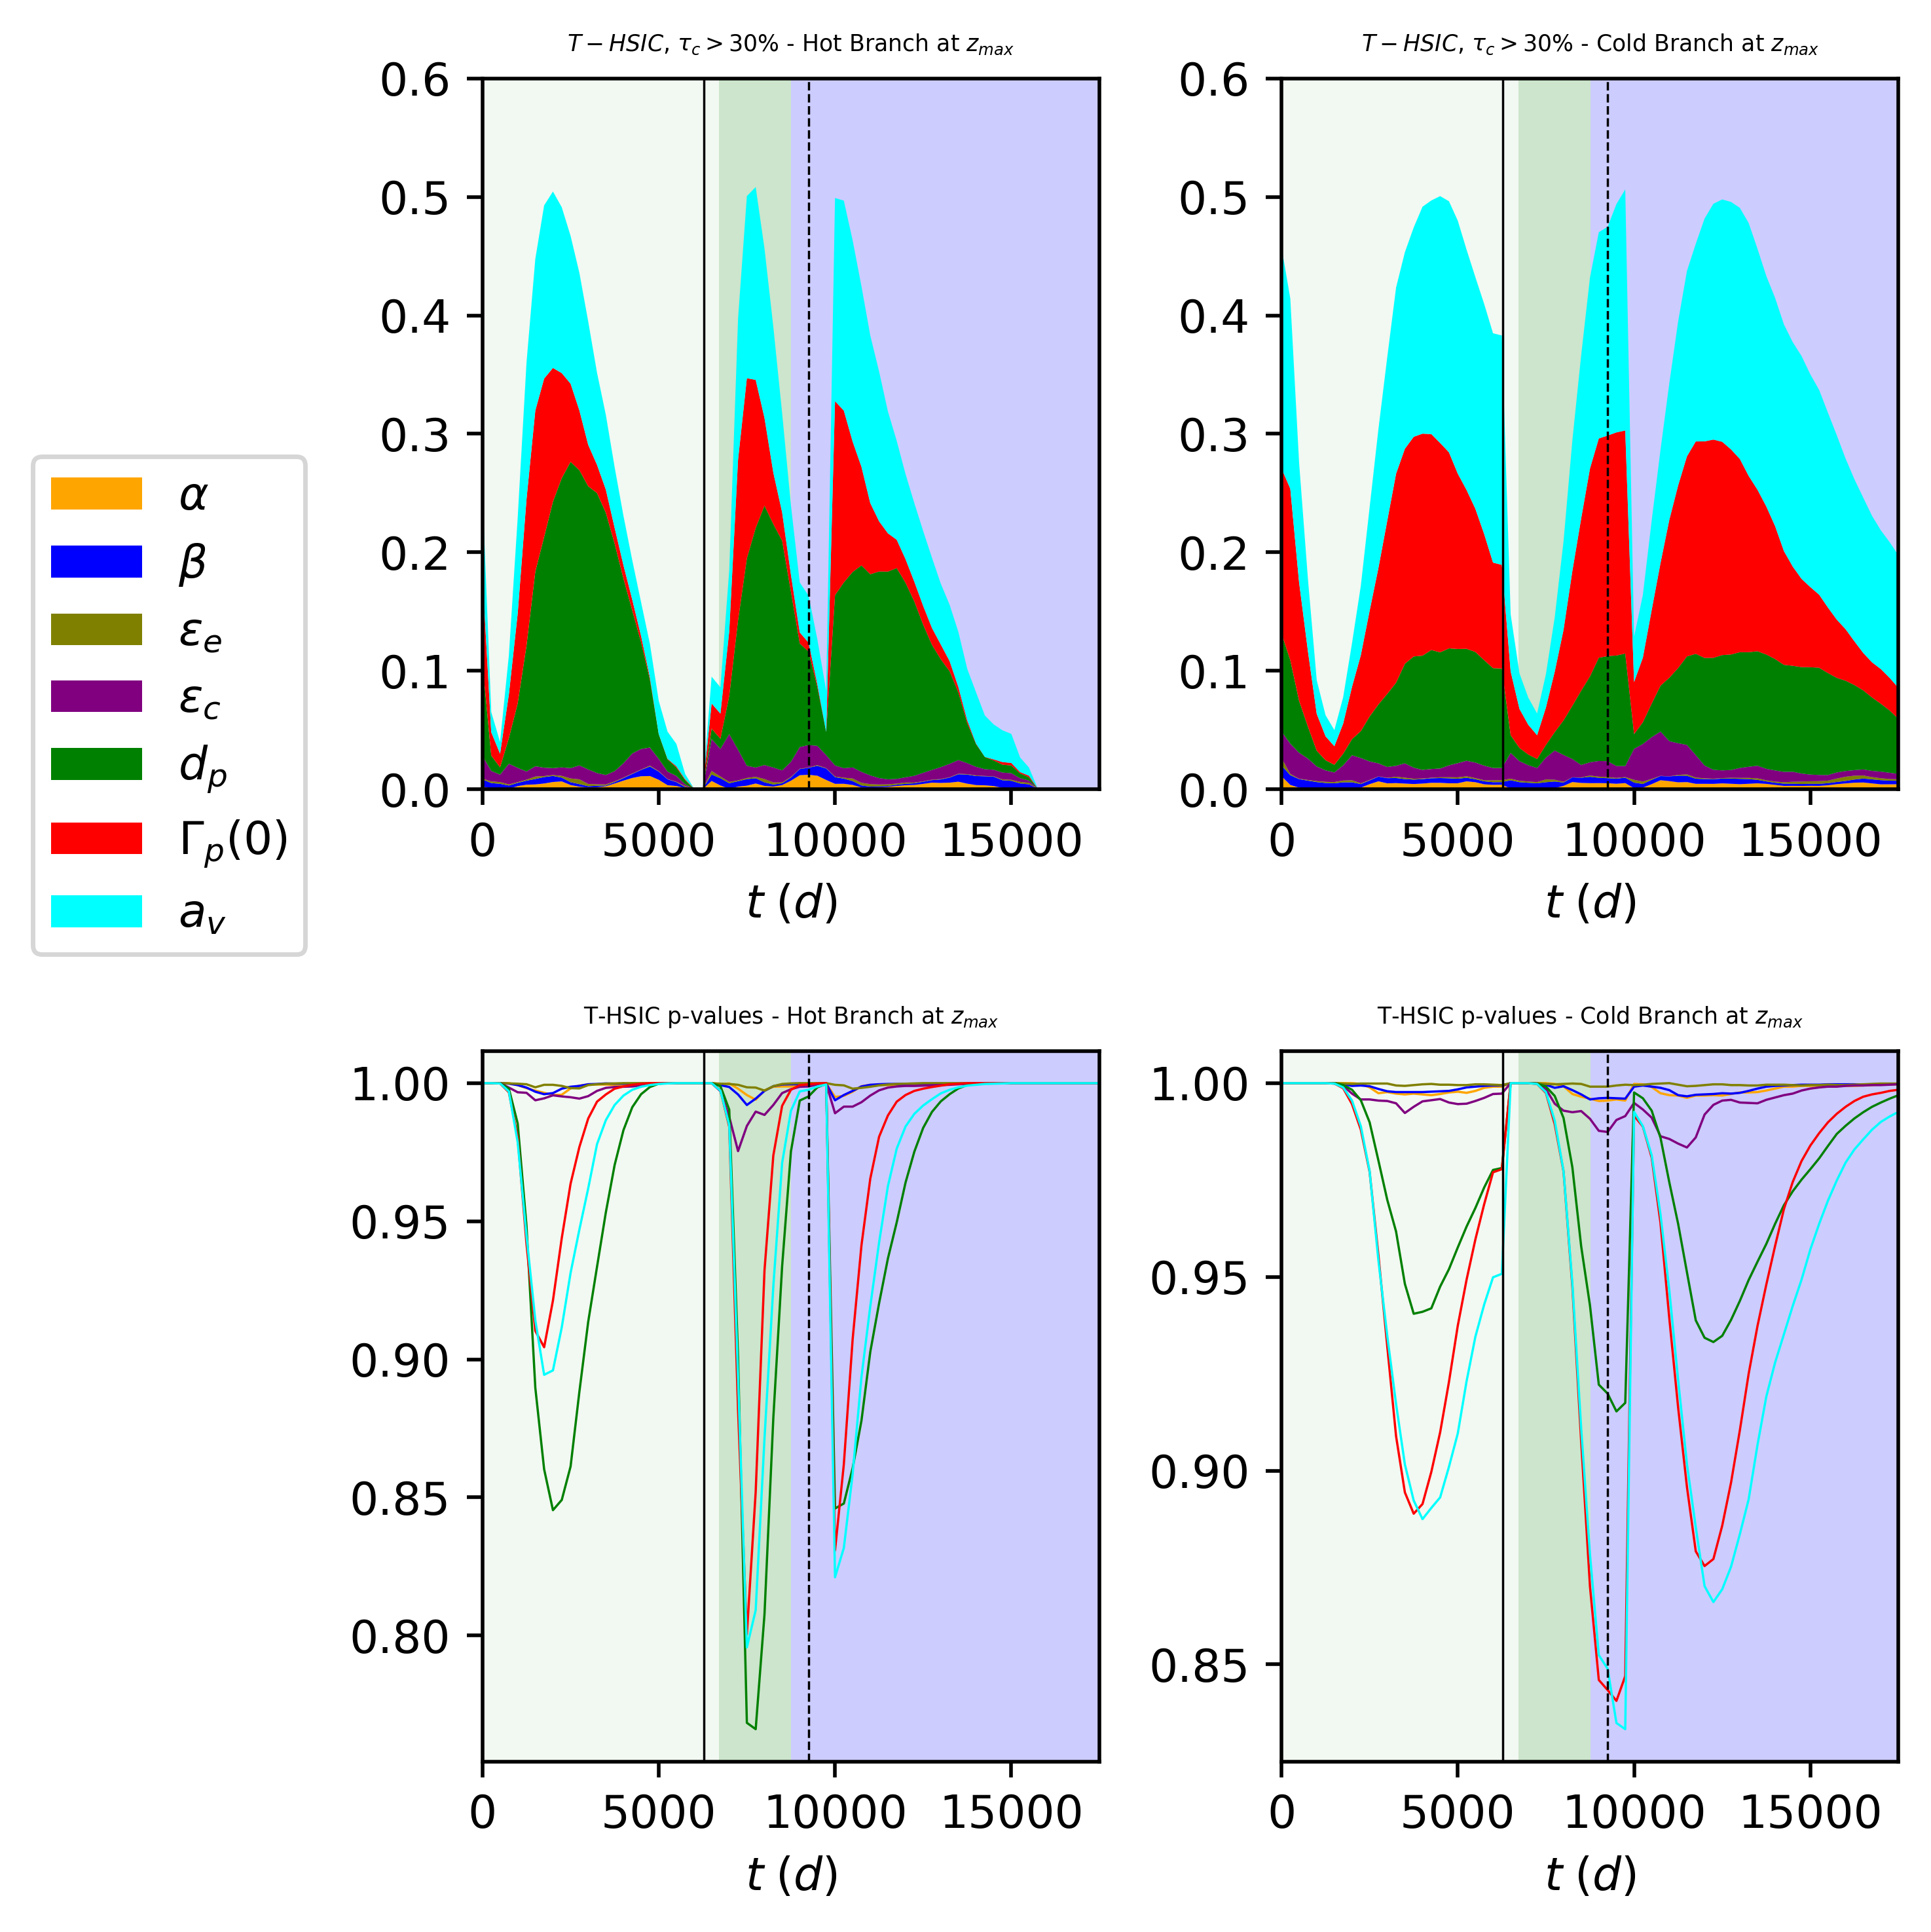

In [15]:
fig, axs = plt.subplots(2,2,figsize=(6,6),layout='tight')
colors = ['orange', 'blue', 'olive','purple', 'green', 'red','cyan']

cond = input_900['CHB4GV2']['chimie']['conditionnementSecondaire']
for k in range(len(cond)):
    if k == len(cond)-1:
        t_i, t_f = cond[k]['nbHeuresExploit']/24, max(t)
    else:
        t_i, t_f = cond[k]['nbHeuresExploit']/24, cond[k+1]['nbHeuresExploit']/24
    c = cond[k]
    typ = colors_ch[c['type']]
    col = typ[str(c['ph'])]
    axs[0,0].axvspan(t_i, t_f, facecolor=col[0], alpha = col[1])
    axs[0,1].axvspan(t_i, t_f, facecolor=col[0], alpha = col[1])
    axs[1,0].axvspan(t_i, t_f, facecolor=col[0], alpha = col[1])
    axs[1,1].axvspan(t_i, t_f, facecolor=col[0], alpha = col[1])

axs[0,0].stackplot(t,hsic_target_time_BC, labels=labels, colors=colors)
axs[0,0].set_xlim(0,17500)
axs[0,0].set_ylim(0,0.6)
axs[0,0].set_xlabel(r'$t\;(d)$')
axs[0,0].set_title(r'$T-HSIC$, $\tau_c > 30\%$ - Hot Branch at $z_{max}$', fontsize=5)

axs[0,1].stackplot(t,hsic_target_time_BF, labels=labels, colors=colors)
axs[0,1].set_xlim(0,17500)
axs[0,1].set_ylim(0,0.6)
axs[0,1].set_xlabel(r'$t\;(d)$')
axs[0,1].set_title(r'$T-HSIC$, $\tau_c > 30\%$ - Cold Branch at $z_{max}$',  fontsize=5)

for k in range(7):
    axs[1,0].plot(t,p_values_target_BC[k], c=colors[k], linewidth=0.5)
    axs[1,0].set_xlim(0,17500)
    #axs[1,0].set_ylim(0,1.15)
    axs[1,0].set_xlabel(r'$t\;(d)$')
    axs[1,0].set_title(r'T-HSIC p-values - Hot Branch at $z_{max}$',  fontsize=5)

    axs[1,1].plot(t,p_values_target_BF[k], c=colors[k], linewidth=0.5)
    axs[1,1].set_xlim(0,17500)
    #axs[1,1].set_ylim(0,1.15)
    axs[1,1].set_xlabel(r'$t\;(d)$')
    axs[1,1].set_title(r'T-HSIC p-values - Cold Branch at $z_{max}$',  fontsize=5)

axs[0,0].legend(bbox_to_anchor=(-0.25,0.5))


nett = input_900['CHB4GV2']['chimie']['nettoyage']
for k in range(len(nett)):
    if nett[k]['type'] == 'curatif':
        axs[0,0].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='-', linewidth=0.5)
        axs[0,1].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='-', linewidth=0.5)
        axs[1,0].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='-', linewidth=0.5)
        axs[1,1].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='-', linewidth=0.5)
        
    elif nett[k]['type'] == 'preventif':
        axs[0,0].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='--', linewidth=0.5)
        axs[0,1].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='--', linewidth=0.5)
        axs[1,0].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='--', linewidth=0.5)
        axs[1,1].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='--', linewidth=0.5)

fig.savefig('HSIC_target_tot.pdf', format='pdf')

# Conditional HSIC

In [9]:
#WORKS ONLY WITH VSTAT
hsic_cond_time_BC, hsic_cond_time_BF = [], []
p_values_cond_BC, p_values_cond_BF = [], []
estimatorType_v = ot.HSICVStat() 

In [10]:
dist = ot.DistanceToDomainFunction(ot.Interval(30, float('inf')))
func = ot.SymbolicFunction('x', 'exp(-0.5 * x)')
weight = ot.ComposedFunction(func, dist)

In [11]:
for i in range(75):

    tauSample_BC = outputSample_BC[:,i]
    tauSample_BF = outputSample_BF[:,i]
        
    covarianceModelCollection_BC, covarianceModelCollection_BF = [], []
    
    for i in range(7):
        Xi = inputSample.getMarginal(i)
        Cov = ot.SquaredExponential(1)
        Cov.setScale(Xi.computeStandardDeviation())
        covarianceModelCollection_BC.append(Cov)
        covarianceModelCollection_BF.append(Cov)

    covarianceModelCollection_BC.append(ot.SquaredExponential(tauSample_BC.computeStandardDeviation()))
    covarianceModelCollection_BF.append(ot.SquaredExponential(tauSample_BF.computeStandardDeviation()))

    hsic_v_cond_BC = ot.HSICEstimatorConditionalSensitivity(covarianceModelCollection_BC, inputSample, tauSample_BC, weight)
    hsic_v_cond_BF = ot.HSICEstimatorConditionalSensitivity(covarianceModelCollection_BF, inputSample, tauSample_BF, weight)
    
    r2_v_cond_BC = hsic_v_cond_BC.getR2HSICIndices()
    r2_v_cond_BF = hsic_v_cond_BF.getR2HSICIndices()

    hsic_cond_time_BC.append(list(np.abs(r2_v_cond_BC)))
    hsic_cond_time_BF.append(list(np.abs(r2_v_cond_BF)))
    
    #hsic_cond_time_BC.append(hsic_u_cond_BC.getHSICIndices())
    #hsic_cond_time_BF.append(hsic_u_cond_BF.getHSICIndices())

    small_p_bc, small_p_bf = [], []
    for j in range(7):
        small_p_bc.append(round(estimatorType_v.computePValue(ot.Gamma(), 969, hsic_v_cond_BC.getR2HSICIndices()[j], 0.0),4))
        small_p_bf.append(round(estimatorType_v.computePValue(ot.Gamma(), 969, hsic_v_cond_BF.getR2HSICIndices()[j], 0.0),4))

    p_values_cond_BC.append(small_p_bc)
    p_values_cond_BF.append(small_p_bf)

In [12]:
hsic_cond_time_BC = list(np.transpose(np.asarray(hsic_cond_time_BC)))
hsic_cond_time_BF = list(np.transpose(np.asarray(hsic_cond_time_BF)))
p_values_cond_BC = list(np.transpose(np.asarray(p_values_cond_BC)))
p_values_cond_BF = list(np.transpose(np.asarray(p_values_cond_BF)))

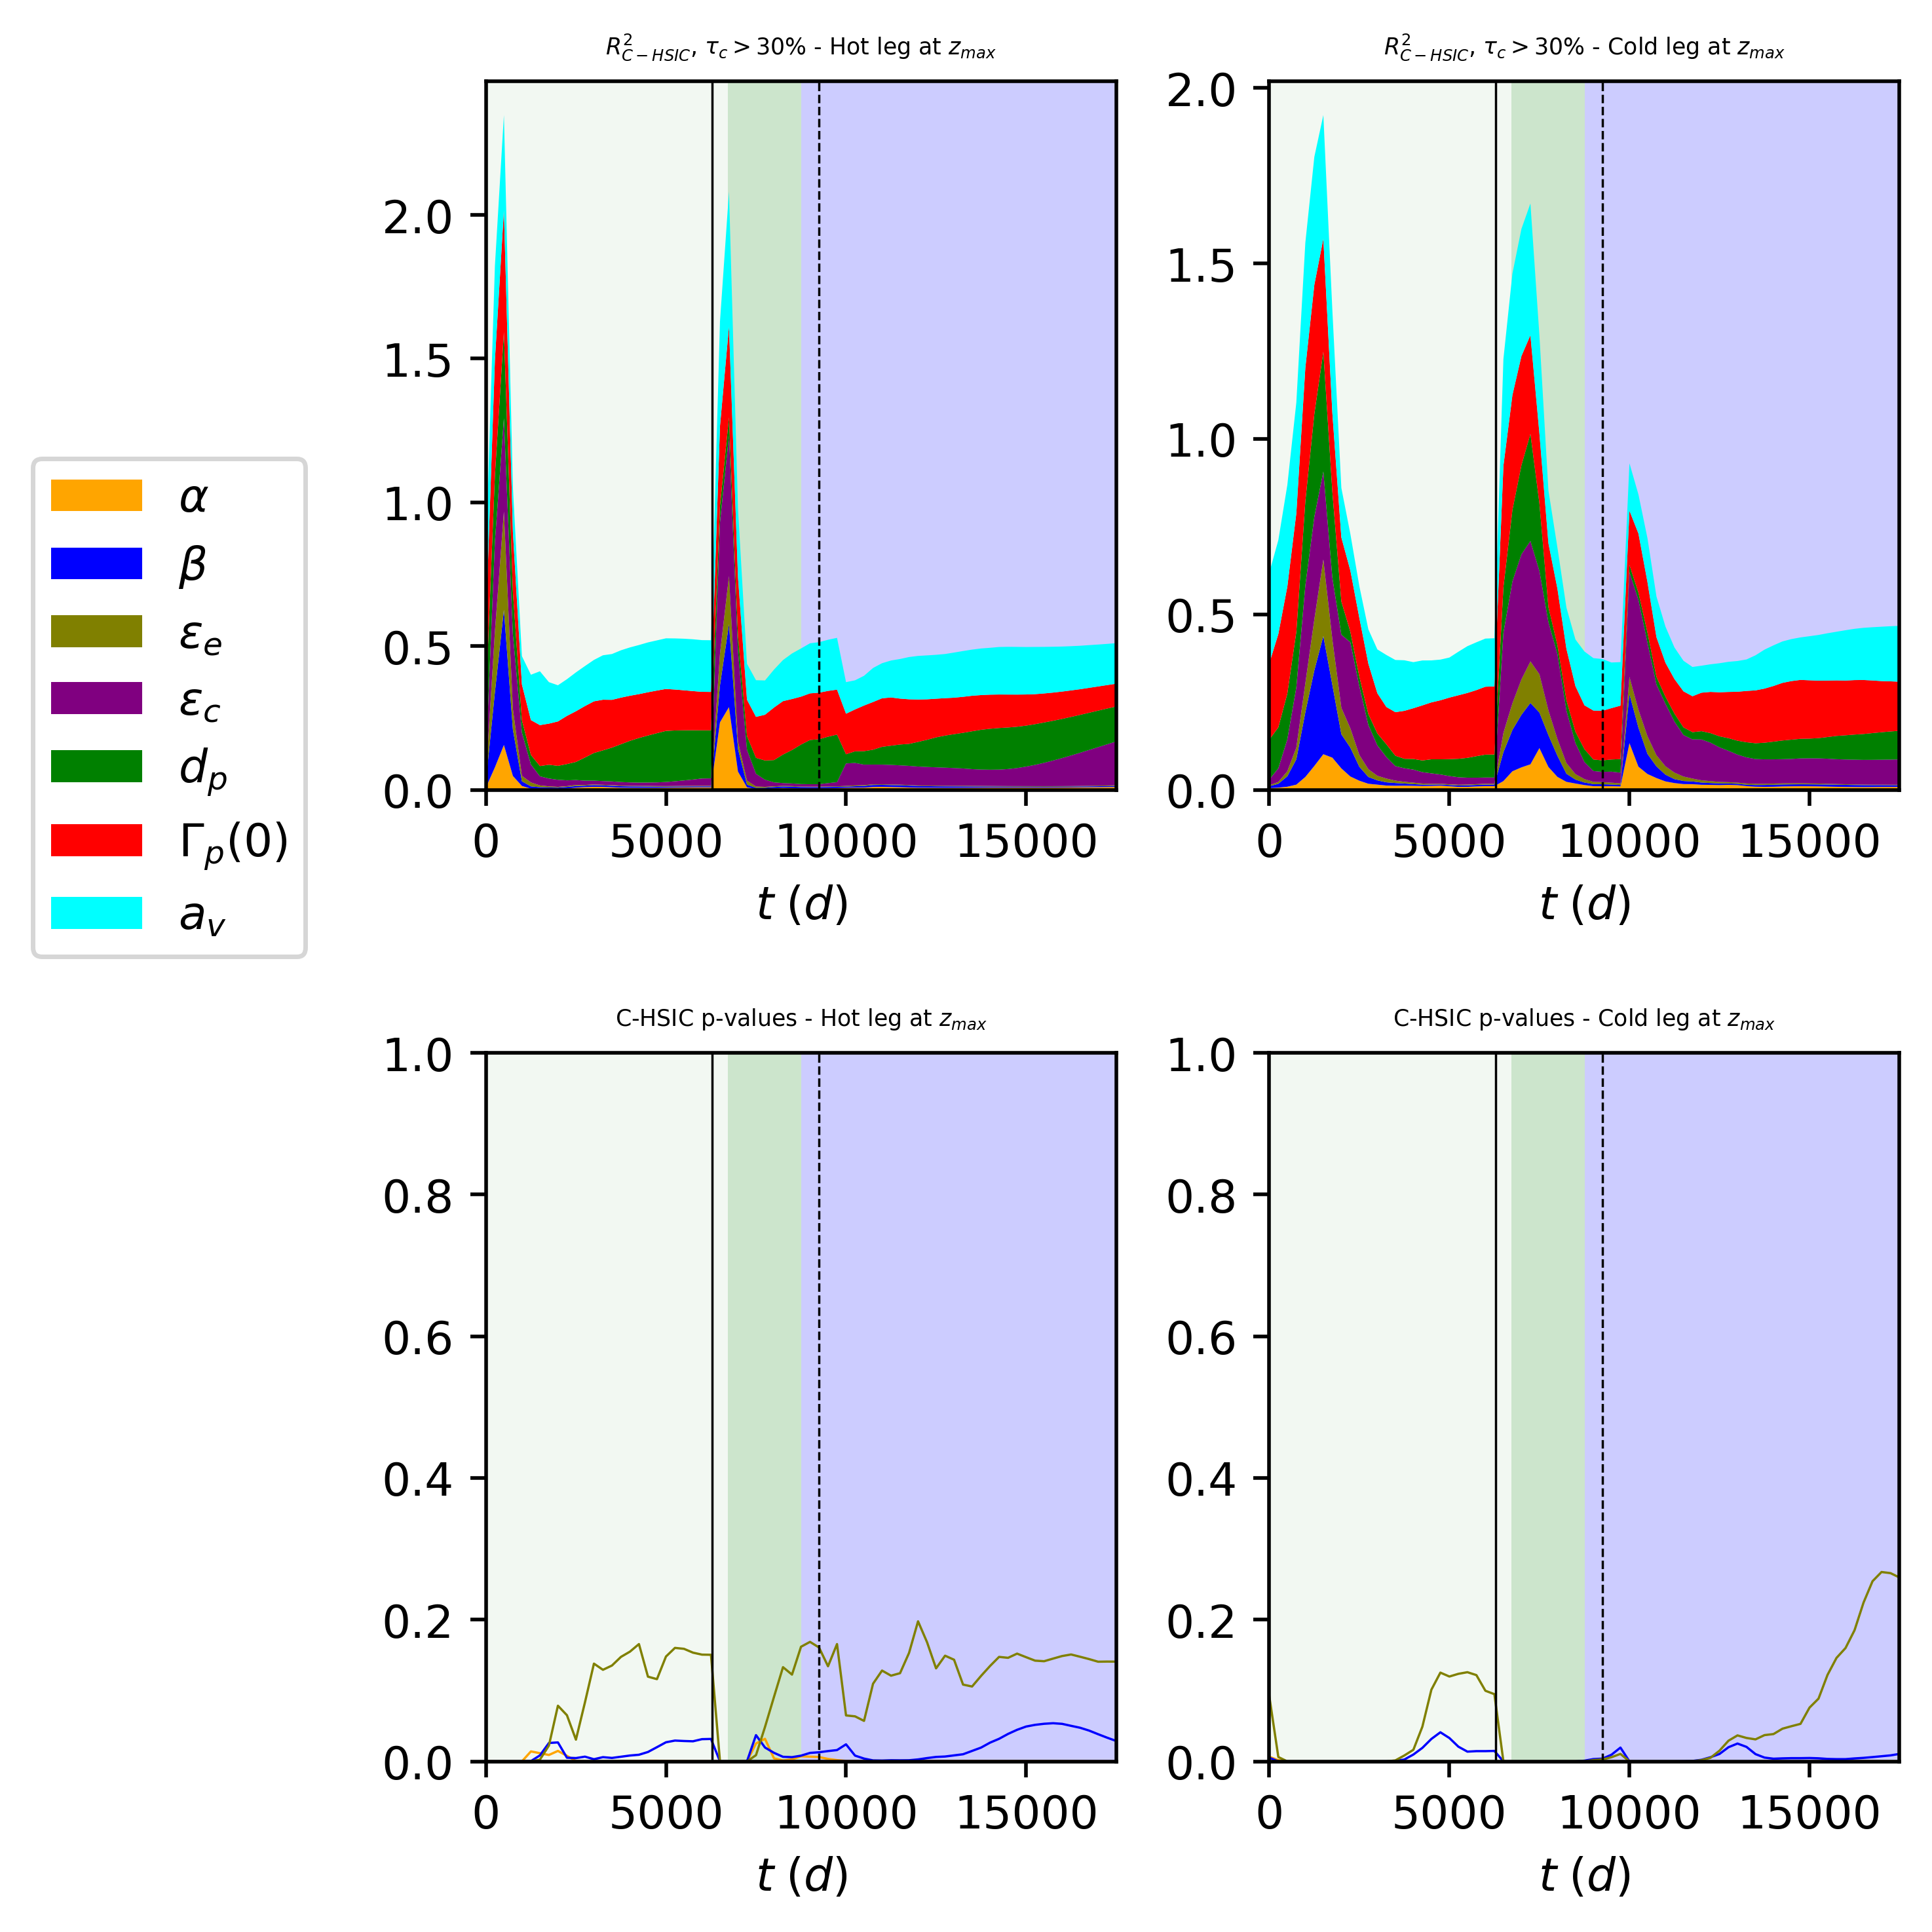

In [14]:
fig, axs = plt.subplots(2,2,figsize=(6,6),layout='tight')
colors = ['orange', 'blue', 'olive','purple', 'green', 'red','cyan']

cond = input_900['CHB4GV2']['chimie']['conditionnementSecondaire']
for k in range(len(cond)):
    if k == len(cond)-1:
        t_i, t_f = cond[k]['nbHeuresExploit']/24, max(t)
    else:
        t_i, t_f = cond[k]['nbHeuresExploit']/24, cond[k+1]['nbHeuresExploit']/24
    c = cond[k]
    typ = colors_ch[c['type']]
    col = typ[str(c['ph'])]
    axs[0,0].axvspan(t_i, t_f, facecolor=col[0], alpha = col[1])
    axs[0,1].axvspan(t_i, t_f, facecolor=col[0], alpha = col[1])
    axs[1,0].axvspan(t_i, t_f, facecolor=col[0], alpha = col[1])
    axs[1,1].axvspan(t_i, t_f, facecolor=col[0], alpha = col[1])

axs[0,0].stackplot(t,hsic_cond_time_BC, labels=labels, colors=colors)
axs[0,0].set_xlim(0,17500)
#axs[0,0].set_ylim(0,0.6)
axs[0,0].set_xlabel(r'$t\;(d)$')
axs[0,0].set_title(r'$R^{2}_{C-HSIC}$, $\tau_c > 30\%$ - Hot leg at $z_{max}$', fontsize=5)

axs[0,1].stackplot(t,hsic_cond_time_BF, labels=labels, colors=colors)
axs[0,1].set_xlim(0,17500)
#axs[0,1].set_ylim(0,0.6)
axs[0,1].set_xlabel(r'$t\;(d)$')
axs[0,1].set_title(r'$R^{2}_{C-HSIC}$, $\tau_c > 30\%$ - Cold leg at $z_{max}$',  fontsize=5)

for k in range(7):
    axs[1,0].plot(t,p_values_cond_BC[k], c=colors[k], linewidth=0.5)
    axs[1,0].set_xlim(0,17500)
    axs[1,0].set_ylim(0,1.0)
    axs[1,0].set_xlabel(r'$t\;(d)$')
    axs[1,0].set_title(r'C-HSIC p-values - Hot leg at $z_{max}$',  fontsize=5)

    axs[1,1].plot(t,p_values_cond_BF[k], c=colors[k], linewidth=0.5)
    axs[1,1].set_xlim(0,17500)
    axs[1,1].set_ylim(0,1.0)
    axs[1,1].set_xlabel(r'$t\;(d)$')
    axs[1,1].set_title(r'C-HSIC p-values - Cold leg at $z_{max}$',  fontsize=5)
axs[0,0].legend(bbox_to_anchor=(-0.25,0.5))


nett = input_900['CHB4GV2']['chimie']['nettoyage']
for k in range(len(nett)):
    if nett[k]['type'] == 'curatif':
        axs[0,0].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='-', linewidth=0.5)
        axs[0,1].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='-', linewidth=0.5)
        axs[1,0].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='-', linewidth=0.5)
        axs[1,1].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='-', linewidth=0.5)
        
    elif nett[k]['type'] == 'preventif':
        axs[0,0].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='--', linewidth=0.5)
        axs[0,1].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='--', linewidth=0.5)
        axs[1,0].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='--', linewidth=0.5)
        axs[1,1].axvline(x=nett[k]['nbHeuresExploit']/24, color = 'k', linestyle='--', linewidth=0.5)

fig.savefig('HSIC_cond_tot.pdf', format='pdf')